# USAGE EXAMPLES FOR SIMPLESEDML

This notebook provides examples of using ``SimpleSBML``.

In [1]:
from src.simple_sedml import SimpleSEDML

/Users/jlheller/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Model

In [2]:
MODEL_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
end
'''

# Basic Usage

In [3]:
# Compose an experiment
ssed = SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, k1=3, ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addReportVariables("time", "S1", "S2", "S3")
ssed.addPlot("time", "S2", title="my plot")

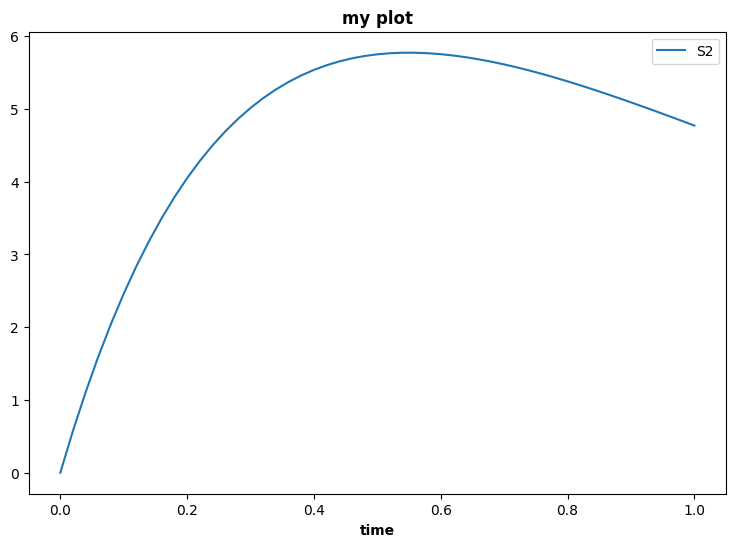

In [4]:
# Run the descript
df = ssed.execute()

In [5]:
df.head(10)

,time,S1,S2,S3
0,0.00,10.000000,0.000000,0.000000
1,0.02,9.417645,0.576512,0.005843
2,0.04,8.869204,1.108035,0.022761
3,0.06,8.352702,1.597415,0.049883
4,0.08,7.866278,2.047328,0.086394
5,0.10,7.408182,2.460289,0.131530
6,0.12,6.976762,2.838663,0.184575
7,0.14,6.570467,3.184674,0.244860
8,0.16,6.187832,3.500409,0.311759
9,0.18,5.827481,3.787832,0.384687


In [6]:
ssed.getGlobalParameters()

[['k1', 'k2']]